In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [46]:
# Conventional demodulation
def demapper_sym(symbols_I, symbols_Q, Ns, threshold = 2.0):
   symbol = []
   for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: #-3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: #-3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: #-1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: #-1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: #1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: #1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: #3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: #3-3j
            symbol.append(10)
   return np.array(symbol)

# Function tha calculate the bit error rate (BER) of two vectors with 4 bits
def bit_error_rate(y_pred, y_test):
    pred = ''.join([f"{sym:04b}" for sym in y_pred])
    test = ''.join([f"{sym:04b}" for sym in y_test])

    pred = np.array(list(pred))
    test = np.array(list(test))

    # Calculate the BER with the two strings
    ber = 0
    for i, j in zip(pred, test):
        if i != j:
            ber += 1
    
    return ber/len(pred)

# Function that calculate the symbol error rate (SER) of two vectors
def symbol_error_rate(y_pred, y_test):
    # Calculate the SER
    return np.sum(y_pred!=y_test)/len(y_pred)

# Add noise to the signal
def add_noise(signal, target_snr_db):
    X_avg_p = np.mean(signal**2)
    X_avg_db = 10 * np.log10(X_avg_p)
    noise_avg_db_r = X_avg_db - target_snr_db
    noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
    mean_noise = 0
    noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(signal))
    return signal + noise_r

# Function that sincronize the signals
def sync_signals(tx, rx):
    trans = np.concatenate((tx, tx))
    corr = np.abs(np.correlate(np.abs(trans) - np.mean(np.abs(trans)),
                        np.abs(rx) - np.mean(np.abs(rx)), mode='full'))
    delay = np.argmax(corr) - len(rx) + 1
    signal = trans[delay:]
    signal = signal[:len(rx)]
    return signal

# Function that demodulate the signal 16-QAM
def demodulate(signal):
    mod_dict = {-3+3j:0, -3+1j:1, -3-3j:2, -3-1j:3,
            -1+3j:4, -1+1j:5, -1-3j:6, -1-1j:7,
            3+3j:8, 3+1j:9, 3-3j:10, 3-1j:11,
            1+3j:12, 1+1j:13, 1-3j:14, 1-1j:15}
    symbols = []
    for i in range(len(signal)):
        symbols.append(mod_dict[signal[i]])
    return np.array(symbols)

In [47]:
# import .mat file
df_tx = pd.DataFrame()
file = sio.loadmat('DB\\2x16QAM_16GBd.mat')
df_tx['Tx'] = file['Constellation'][0][0][0][0]
df_tx.head()

,Tx
0,3.0+3.0j
1,-3.0-3.0j
2,3.0-1.0j
3,-3.0+3.0j
4,-3.0+3.0j


In [48]:
OSNR = [18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40]
df_rx = pd.DataFrame()
for val in OSNR:
    rot = np.pi/2
    if val == 32 or val == 35 or val == 40:
        rot = 0
    elif val == 20 or val == 27:
        rot = np.pi
    elif val == 23:
        rot = 3*np.pi/2
    file = sio.loadmat('DB\\17.6GHz\\16QAM_3x16GBd_consY'+str(val)+'dB.mat')
    
    # Normalize the signal between -3 and 3
    file = file['const_Y'][0]
    file = (file - np.mean(file))/np.std(file)
    file = file * 3
    df_rx[str(val)+'dB'] = file*np.exp(1j*rot)
df_rx.head()

,18dB,19dB,20dB,21.5dB,23dB,25dB,27dB,30dB,32dB,35dB,40dB
0,1.626492+2.276238j,-3.067255-2.386235j,-0.991821+3.327793j,-0.641464-2.795975j,1.030519+1.216022j,1.362733-1.011730j,0.350971+3.107882j,-2.557394-1.048550j,2.956327-2.773451j,-3.014899-2.306891j,2.828578-0.528511j
1,-2.105216-0.564304j,1.329848-0.520526j,1.079530-1.034995j,0.980756-0.598601j,2.300576-1.181632j,0.953809-0.894247j,3.192750-0.796437j,3.269885-0.951876j,1.122311-0.963413j,-0.376329-1.230109j,-0.914368-1.013349j
2,1.502568+0.461938j,-0.529428-2.370793j,2.001683-0.050677j,2.327231+1.570579j,2.413613-3.292016j,-1.041223-2.808904j,-1.027732-0.736211j,-3.172217+2.878930j,-0.842271-0.825502j,0.975790-0.877451j,-0.638947-0.789444j
3,-0.630973+2.299316j,0.584606+0.878542j,-3.493043+2.015965j,-2.900900-1.449225j,-2.678520-2.057911j,0.062483+2.639000j,-2.437699-1.021427j,1.184870-1.031015j,-0.937304-0.698437j,-2.611427-1.325507j,2.651689-1.137963j
4,-2.672307-0.927133j,-1.085365-2.180546j,3.074910+1.670417j,-0.893978-0.839459j,-0.555547-3.322574j,-0.772407+3.066999j,-0.945729-2.821320j,0.431000+2.620946j,2.856735-3.140244j,0.893011-0.900371j,-2.928027+1.153818j


In [49]:
sync_sym = [sync_signals(df_tx['Tx'], df_rx[str(val)+'dB']) for val in OSNR]

In [50]:
y = [demodulate(sync_sym[i]) for i in range(len(OSNR))]

In [51]:
Xr = [np.real(df_rx[str(val)+'dB']) for val in OSNR]
Xi = [np.imag(df_rx[str(val)+'dB']) for val in OSNR]

In [52]:
sym_dem = [demapper_sym(Xr[i], Xi[i], len(Xr[i])) for i in range(len(OSNR))]

In [53]:
ber = [bit_error_rate(sym_dem[i], y[i]) for i in range(len(OSNR))]

In [54]:
model = KNeighborsClassifier(n_neighbors=15)
ber_knn = []
for i in range(len(OSNR)):
    X = np.transpose(np.array([Xr[i], Xi[i]]))
    X_test, X_train, y_test, y_train = train_test_split(X, y[i], test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ber_knn.append(bit_error_rate(y_pred, y_test))

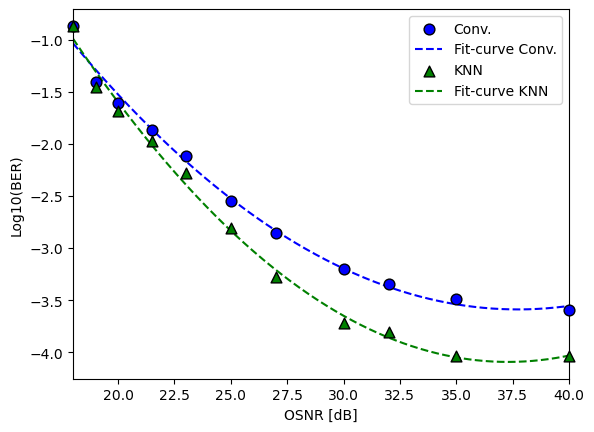

In [55]:
# Fit-curve of the BER
p1 = np.polyfit(OSNR, np.log10(ber), 2)
z1 = np.poly1d(p1)

p2 = np.polyfit(OSNR, np.log10(ber_knn), 2)
z2 = np.poly1d(p2)

x_step = np.linspace(np.min(OSNR), np.max(OSNR), 1000) # step between 4 and 16 dB

# Plot ther BER vs OSNR
plt.scatter(OSNR, np.log10(ber), color='blue', edgecolors='black',
            marker='o', s=60, zorder=3, clip_on=False, label='Conv.')
plt.plot(x_step, z1(x_step), '--b', label='Fit-curve Conv.')

plt.scatter(OSNR, np.log10(ber_knn), color='green', edgecolors='black',
            marker='^', s=60, zorder=3, clip_on=False, label='KNN')
plt.plot(x_step, z2(x_step), '--g', label='Fit-curve KNN')

plt.xlabel('OSNR [dB]')
plt.ylabel('Log10(BER)')
plt.xlim([np.min(OSNR), np.max(OSNR)])
plt.legend()
plt.show()